# LSTM model
from https://github.com/Xinyi6/DP-LSTM-Differential-Privacy-inspired-LSTM-for-Stock-Prediction-Using-Financial-News and make some changes

### Where we can use big compute:
- Adding noises to data
- The computations of multi-sequence predictions
- The calculation of MSE

### Where we cannot use big compute:
- The training of LSTM


In [95]:
! pip install vaderSentiment

## COG Model

In [2]:
import json
import time
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt
from numpy import newaxis
from keras.layers import Dense, Activation, Dropout, LSTM
from keras.models import Sequential, load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

from math import pi,sqrt,exp,pow,log
from numpy.linalg import det, inv
from abc import ABCMeta, abstractmethod
from sklearn import cluster

import statsmodels.api as sm 
import scipy.stats as scs
import scipy.optimize as sco
import scipy.interpolate as sci
from scipy import stats

import matplotlib.pyplot as plt

stock = 'COG'
industry = 'energy'

In [4]:
# read data
data = pd.read_csv('../../data/processed_data/data/processed_data_' + industry + '_15.csv')
data.head(5)

,window,NewsScore,StockPrice_IXIC,StockPrice_COG,StockPrice_DVN,StockPrice_HFC
0,"Row(start=datetime.datetime(2016, 3, 30, 20, 0...","[0.23850909090909092, 0.2385090909090909, 0.40...","[0.3166683053825404, 0.3191221042821783, 0.080...","[0.3137250502081253, 0.2941167670829173, 0.0, ...","[0.07142854769352029, 0.31881533043154925, 0.1...","[0.25229319269118106, 0.6605497362959645, 0.27..."
1,"Row(start=datetime.datetime(2016, 3, 31, 20, 0...","[0.4082222222222222, 0.4082222222222222, 0.636...","[0.08010755676013047, 0.7103833312671264, 0.70...","[0.0, 0.163398619479132, 0.17647055890276483, ...","[0.1347148381536994, 0.17271160126062918, 0.17...","[0.27981675456801186, 0.1467888302879921, 0.11..."
2,"Row(start=datetime.datetime(2016, 4, 1, 20, 0)...","[0.6362, 0.6362, 0.3410333333333333, 0.3410333...","[0.704552352697255, 0.6987213741273838, 0.6928...","[0.15436295907525793, 0.16778581395051093, 0.1...","[0.17651121168707462, 0.18031082211352065, 0.1...","[0.11824019088165469, 0.08890933960654429, 0.0..."
3,"Row(start=datetime.datetime(2016, 4, 2, 20, 0)...","[0.3410333333333333, 0.3410333333333333, 0.422...","[0.6928903955575125, 0.6870594169876413, 0.681...","[0.1812086688257663, 0.19463152370101927, 0.20...","[0.1841104325399661, 0.18791004296641212, 0.19...","[0.14285705180339398, 0.11612357960701916, 0.0..."
4,"Row(start=datetime.datetime(2016, 4, 3, 20, 0)...","[0.42273333333333335, 0.42273333333333335, 0.4...","[0.6145157682845002, 0.4612213575609869, 0.177...","[0.20805437857627465, 0.2684570975050884, 0.08...","[0.1737087338069369, 0.06885738164885678, 0.0,...","[0.1279998779296875, 0.3959991455078125, 0.311..."


In [5]:
data.iloc[-2:]

,window,NewsScore,StockPrice_IXIC,StockPrice_COG,StockPrice_DVN,StockPrice_HFC
1827,"Row(start=datetime.datetime(2021, 3, 31, 20, 0...","[0.6960999999999999, 0.899, 0.7917761904761904...","[0.0, 0.10535855595487202, 0.1316198322513374,...","[0.9240505310394724, 1.0, 0.9867390454821439, ...","[0.2707181854681067, 1.0, 0.9928965920171047, ...","[0.4204543607294307, 1.0, 0.9963473968797198, ..."
1828,"Row(start=datetime.datetime(2021, 4, 1, 20, 0)...","[0.7917761904761904, 0.8606666666666667, 0.740...",NaN,NaN,NaN,NaN


In [6]:
data = data.iloc[:-1]
# ratio of train and test data 0.8:0.2
train_len = int(len(data)*0.8)
test_len = len(data) - train_len

### 2. Processing data

In [7]:
def str2num(row):
    l = row.split(',')
    result = []
    result.append(float(l[0][1:]))
    for n in l[1:-1]:
        result.append(float(n))
    result.append(float(l[-1][:-1]))
    return result

In [8]:
df_prices_train = list(data['StockPrice_' + stock.upper()][:train_len])  # 1896 x 24 list of stock prices: df_prices_train[0]: stock price 0th row
df_prices_test = list(data['StockPrice_' + stock.upper()][train_len:])
df_senti_train = list(data['NewsScore'][:train_len])
df_senti_test = list(data['NewsScore'][train_len:])


In [9]:
# prepare train and test data
def input_data(df_prices, df_senti):
    x = []
    y = []
    min_max = []
    for i, row in enumerate(df_prices):
        if type(row) == float:
            print(row)
        prices = str2num(row)
        senti = str2num(df_senti[i])
        one_row = []
        for i, p in enumerate(prices[:-3]):
            one_row.append([p, senti[i]])
        x.append(one_row)
        y.append(prices[21:-2])
        min_max.append(prices[-2:])
    x = np.array(x)
    y = np.array(y)
    return x, y, min_max

In [10]:
x_train, y_train, min_max_train = input_data(df_prices_train, df_senti_train)
x_test, y_test, min_max_test = input_data(df_prices_test, df_senti_test)
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(1462, 29, 2) (1462, 9) (366, 29, 2) (366, 9)


## Convert to: 21 prices predict n prices

In [16]:
def conv_ny(y, n, min_max):
    '''
    n: the number of prices to be predicted
    y_test: (367,) y0, y1, y2
    y_test_10: (357, 10)
    y_test_10[0]: [y0, y1, y2, ..., y10]
    y_test_10[1]: [y1, y2, y3, ..., y11]

    '''
    yn = []  # final result of dimension (x, n)
    size = len(y)  # data size of y
    for i in range(size-(n+1)): # no last n prices in y 
        newy = [y[i]]
        min_i = min_max[i][0]
        max_i = min_max[i][1]
        diff_i = max_i - min_i
        for j in range(1, n):
            min_j = min_max[i+j][0]
            max_j = min_max[i+j][1]
            diff_j = max_j - min_j
            newy.append((y[i+j] * diff_j + min_j - min_i)/diff_i)
        yn.append(newy)
    return np.array(yn)

In [67]:
n = 10
y_train_10, y_test_10 = conv_ny(y_train, n, min_max_train), conv_ny(y_test, n, min_max_test)
x_train_10 = x_train[:len(y_train_10)]
x_test_10 = x_test[:len(y_test_10)]
print(x_train_10.shape, y_train_10.shape, x_test_10.shape, y_test_10.shape)

(1454, 21, 2) (1454, 10) (356, 21, 2) (356, 10)


In [94]:
print(y_test[0:10], y_test_10[0])

[1.         1.         0.69847303 1.         0.89322042 0.75769262
 1.         0.81349237 0.69047597 0.42063539] [1.         1.20794765 0.89371471 1.65619118 1.53974035 1.42328953
 1.86876088 1.68853941 1.54528559 1.23105353]


## Model training

In [13]:
# model parameters setting to predict n prices
n = 9
split = 0.85 # train_data percent

normalise= True  # normalize 3 features
batch_size=64;
input_dim=x_train.shape[2]  # ['price','sentiment']
input_timesteps=x_train.shape[1] # the window length of a training data set
neurons=10  # number of neurons in one LSTM layer
epochs=200
prediction_len=1  # predict one day's price
dense_output=n  # output size of the last dense layer
drop_out=0.1  # dropout rate

In [14]:
# Build LSTM MODEL to predict 9 prices
model = Sequential()
model.add(LSTM(neurons, input_shape=(input_timesteps, input_dim), return_sequences = True))
model.add(Dropout(drop_out))
model.add(LSTM(neurons,return_sequences = True))
model.add(LSTM(neurons,return_sequences =False))
model.add(Dropout(drop_out))
model.add(Dense(dense_output, activation='linear'))
# Compile model
model.compile(loss='mean_squared_error',
                optimizer='adam')
# Fit the model
history = model.fit(x_train,y_train,epochs=epochs,batch_size=batch_size)

Epoch 1/200
23/23 [==============================] - 5s 22ms/step - loss: 0.3262
Epoch 2/200
23/23 [==============================] - 0s 19ms/step - loss: 0.2229
Epoch 3/200
23/23 [==============================] - 0s 19ms/step - loss: 0.1554
Epoch 4/200
23/23 [==============================] - 0s 20ms/step - loss: 0.1220
Epoch 5/200
23/23 [==============================] - 1s 23ms/step - loss: 0.1116
Epoch 6/200
23/23 [==============================] - 0s 21ms/step - loss: 0.1019
Epoch 7/200
23/23 [==============================] - 0s 19ms/step - loss: 0.0855
Epoch 8/200
23/23 [==============================] - 0s 20ms/step - loss: 0.0698
Epoch 9/200
23/23 [==============================] - 0s 21ms/step - loss: 0.0618
Epoch 10/200
23/23 [==============================] - 1s 23ms/step - loss: 0.0538
Epoch 11/200
23/23 [==============================] - 1s 26ms/step - loss: 0.0479
Epoch 12/200
23/23 [==============================] - 1s 23ms/step - loss: 0.0465
Epoch 13/200
23/23 [=====

In [28]:
model.save('../model_saved/energy_cog_2016_5.h5')

Text(0.5, 1.0, 'MSE v.s. Epochs')

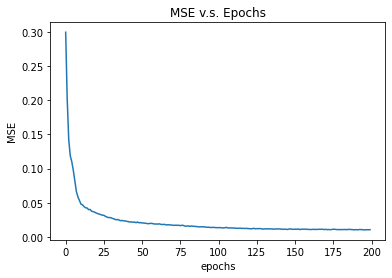

In [15]:
plt.plot(history.history['loss'])
plt.ylabel('MSE')
plt.xlabel('epochs')
plt.title('MSE v.s. Epochs')

In [ ]:
# model parameters setting to predict 1 price
split = 0.85 # train_data percent

normalise= True  # normalize 3 features
batch_size=64;
input_dim=2  # ['price','sentiment']
input_timesteps=21 # the window length of a training data set
neurons=10  # number of neurons in one LSTM layer
epochs=50
prediction_len=1  # predict one day's price
dense_output=1  # output size of the last dense layer
drop_out=0.1  # dropout rate

In [40]:
# Build LSTM MODEL to predict 1 price
model = Sequential()
model.add(LSTM(neurons, input_shape=(input_timesteps, input_dim), return_sequences = True))
model.add(Dropout(drop_out))
model.add(LSTM(neurons,return_sequences = True))
model.add(LSTM(neurons,return_sequences =False))
model.add(Dropout(drop_out))
model.add(Dense(dense_output, activation='linear'))
# Compile model
model.compile(loss='mean_squared_error',
                optimizer='adam')
# Fit the model
model.fit(x_train,y_train,epochs=epochs,batch_size=batch_size)

Epoch 1/50
23/23 [==============================] - 4s 18ms/step - loss: 0.3322
Epoch 2/50
23/23 [==============================] - 0s 14ms/step - loss: 0.1387
Epoch 3/50
23/23 [==============================] - 0s 15ms/step - loss: 0.1351
Epoch 4/50
23/23 [==============================] - 0s 14ms/step - loss: 0.1297
Epoch 5/50
23/23 [==============================] - 0s 14ms/step - loss: 0.1153
Epoch 6/50
23/23 [==============================] - 0s 14ms/step - loss: 0.1018
Epoch 7/50
23/23 [==============================] - 0s 14ms/step - loss: 0.1047
Epoch 8/50
23/23 [==============================] - 0s 20ms/step - loss: 0.0945
Epoch 9/50
23/23 [==============================] - 0s 19ms/step - loss: 0.0956
Epoch 10/50
23/23 [==============================] - 0s 14ms/step - loss: 0.0926
Epoch 11/50
23/23 [==============================] - 0s 14ms/step - loss: 0.0907
Epoch 12/50
23/23 [==============================] - 0s 18ms/step - loss: 0.0854
Epoch 13/50
23/23 [==================

In [17]:
#multi sequence predict
prediction_seqs = model.predict(x_test) # prediction data
# !! parallelizable !!

'''
for x in x_test:
      temp=model.predict(curr_frame[newaxis,:,:])[0]
      predicted.append(temp)
      curr_frame = curr_frame[1:]
      curr_frame = np.insert(curr_frame, [window_size-2], predicted[-1], axis=0)
    prediction_seqs.append(predicted)
'''

'\nfor x in x_test:\n      temp=model.predict(curr_frame[newaxis,:,:])[0]\n      predicted.append(temp)\n      curr_frame = curr_frame[1:]\n      curr_frame = np.insert(curr_frame, [window_size-2], predicted[-1], axis=0)\n    prediction_seqs.append(predicted)\n'

In [18]:
np.sqrt(mean_squared_error(prediction_seqs, y_test))

0.08349748545013164

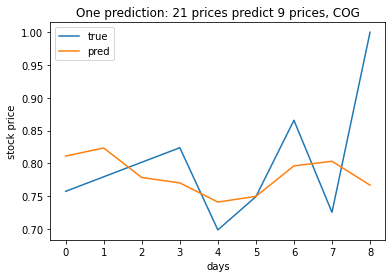

In [26]:
plt.plot(y_test[0], label = 'true')
plt.plot(prediction_seqs[0], label = 'pred')
plt.xlabel('days')
plt.ylabel('stock price')
plt.title('One prediction: 21 prices predict 9 prices, COG')
plt.legend()

### De-normalized


In [20]:
ori_price = pd.read_csv('../../data/stock_price/data/' + industry +'/price_' + stock.upper() + '.csv')

In [21]:
ori_price.head(5)

,Date,Type,ticker,Price
0,2016-03-31,Open,COG,22.740000
1,2016-03-31,Closed,COG,22.709999
2,2016-04-01,Open,COG,22.260000
3,2016-04-01,Closed,COG,22.510000
4,2016-04-04,Open,COG,22.610001


In [22]:
def normalize(x):
    """
    Normalize the input to the range between 0 and 1
    """
    x = np.array(x)
    x_normalized = ((x - np.min(x)) / (np.max(x) - np.min(x))).tolist()
    return x_normalized
max_price = np.max(ori_price['Price'])
min_price = np.min(ori_price['Price'])
def denorm_n(x, min_max, n):
    de_result = []
    for i, v in enumerate(x):
        min_p, max_p = min_max[i]
        v_denorm = []
        for j in range(n):
            v_denorm.append(x[i][j] * (max_p - min_p) + min_p)
        de_result.append(v_denorm)
    return de_result


In [24]:
pred_denorm = denorm_n(prediction_seqs, min_max_test, n)
ytest_denorm = denorm_n(y_test, min_max_test, n)
print('Industry: ', industry, '; stock: ', stock.upper())
print('The max price is {0}, the min price is {1}'.format(max_price, min_price))
print('The RMSE of predictions is', np.sqrt(mean_squared_error(pred_denorm, ytest_denorm)))

Industry:  energy ; stock:  COG
The max price is 29.489999771118164, the min price is 13.09000015258789
The RMSE of predictions is 0.15641416259060492


In [90]:
print(np.array(pred_denorm).shape, np.array(ytest_denorm).shape
)


(356, 10) (356, 10)


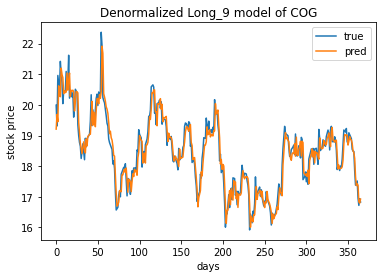

In [27]:
plt.plot(np.array(ytest_denorm)[:, -1], label = 'true')
plt.plot(np.array(pred_denorm)[:, -1], label = 'pred')
plt.xlabel('days')
plt.ylabel('stock price')
plt.title('Denormalized Long_{} model of '.format(n) + stock)
plt.legend()

In [ ]:
# de_normalized
de_predicted=[]
len_pre_win=int(len(data)/prediction_len)
len_pre=prediction_len

m=0
for i in range(0,len_pre_win):
    for j in range(0,len_pre):
      de_predicted.append(prediction_seqs[i][j][0]*record_max[m]+record_min[m])  # record_max is the max difference among prices, and record_min is the minimum price
      m=m+1
print(de_predicted)

# np.save(../stockdata/result2/sp_5dim_n01_7030.npy',de_predicted)

In [ ]:
error = []
diff=y_test.shape[0]-prediction_len*pre_win_num

for i in range(y_test_ori.shape[0]-diff):
    error.append(y_test_ori[i,] - de_predicted[i])
    
squaredError = []
absError = []
for val in error:
    squaredError.append(val * val) 
    absError.append(abs(val))

error_percent=[]
for i in range(len(error)):
    val=absError[i]/y_test_ori[i,]
    val=abs(val)
    error_percent.append(val)

mean_error_percent=sum(error_percent) / len(error_percent)
accuracy=1-mean_error_percent

MSE=sum(squaredError) / len(squaredError)

print("MSE",MSE)
print('accuracy',accuracy)
print('mean_error_percent',mean_error_percent)